# Data Loading

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
data_dir_path = '../data'
filename_train = 'train_data.txt'
filename_test = 'test_data.txt'
filename_labels_test = 'answer.txt'

In [4]:
data_train = np.loadtxt(os.path.join(data_dir_path,filename_train),delimiter = ',')
labels_train = data_train[:,-1]
data_train = data_train[:,:-1]
data_test = np.loadtxt(os.path.join(data_dir_path,filename_test),delimiter = ',')
labels_test = np.loadtxt(os.path.join(data_dir_path,filename_labels_test),delimiter=',')

In [5]:
def myload(file_path):
    with open(file_path,'r') as f:
        lines = f.readlines()
        res = []
        for line in lines:
            res.append(list(map(lambda x:float(x),line.strip().split(','))))
    return np.array(res)


In [6]:
X_train,X_val,Y_train,Y_val = train_test_split(data_train,
                                               labels_train,
                                               train_size=0.8,
                                               random_state=1)

In [7]:
Y_train.sum()/len(Y_train)

0.3665625

In [8]:
import torch
import torch.nn as nn
import torch.optim 
from torch.utils.data import Dataset, DataLoader

In [9]:
de = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [19]:
model = nn.Sequential(
    nn.Linear(1000,100),
    nn.ReLU(),
    nn.Linear(100,50),
    nn.ReLU(),
    nn.Linear(50,20),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(20,1),
    nn.Sigmoid()
).to(de)

In [20]:
num_epochs = 200
batch_size = 100
lossF = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,)

In [21]:
class BankRiskDataSet(Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,i):
        return {"X": torch.from_numpy(self.X[i,:]),
                "Y":torch.tensor(self.Y[i])}

In [22]:
dataset_train = BankRiskDataSet(X_train,Y_train)
dataset_val= BankRiskDataSet(X_val,Y_val)
dataloader_train = DataLoader(dataset_train,batch_size=batch_size,num_workers=4)
dataloader_val = DataLoader(dataset_val,batch_size=batch_size,num_workers=4)

In [23]:
total_avg_loss_train = []
total_avg_loss_val = []
accuracy_train = []
accuracy_val = []
for epoch in range(1,num_epochs+1):
    model.train()
    avg_loss = 0
    n_equal = 0
    for i, data in enumerate(dataloader_train):
        x = data['X'].to(de).float()
        y = data["Y"].to(de).unsqueeze(1)
        y_pre = model(x)
        loss = lossF(y_pre,y)
        n_equal += torch.sum(y_pre.round()==y).item()
        model.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss +=loss
        if i%20==0 :
            print("\tEpoch: {}/{}\t {}/{} \t loss: {}".format(
                epoch,num_epochs,i,len(dataloader_train),loss))
    avg_loss /= len(dataset_train)
    total_avg_loss_train.append(avg_loss)
    accuracy_train.append(n_equal/(i*batch_size))
    print("Epoch: {}/{}, average training loss: {} accuracy: {}".format(
        epoch,num_epochs,avg_loss,n_equal/(i*batch_size)))
    model.eval()
    avg_loss=0
    n_equal = 0
    for i, data in enumerate(dataloader_val):
        x = data['X'].to(de).float()
        y = data["Y"].to(de).unsqueeze(1)
        y_pre = model(x)
        loss = lossF(y_pre,y)
        n_equal += torch.sum(y_pre.round()==y).item()
        avg_loss +=loss
    avg_loss /= len(dataset_val)
    total_avg_loss_val.append(avg_loss)
    accuracy_val.append(n_equal/(i*batch_size))
    print("Epoch: {}/{}, average validation loss: {} accuracy: {}".format(
        epoch,num_epochs,avg_loss,n_equal/(i*batch_size)))
    print(''.join(['-']*100))

	Epoch: 1/200	 0/64 	 loss: 73.9177474975586
	Epoch: 1/200	 20/64 	 loss: 69.18535614013672
	Epoch: 1/200	 40/64 	 loss: 66.83660888671875
	Epoch: 1/200	 60/64 	 loss: 70.148681640625
Epoch: 1/200, average training loss: 0.6859992146492004 accuracy: 0.5419047619047619
Epoch: 1/200, average validation loss: 0.6623941659927368 accuracy: 0.6646666666666666
----------------------------------------------------------------------------------------------------
	Epoch: 2/200	 0/64 	 loss: 62.82323455810547
	Epoch: 2/200	 20/64 	 loss: 63.169132232666016
	Epoch: 2/200	 40/64 	 loss: 64.71414184570312
	Epoch: 2/200	 60/64 	 loss: 71.31439208984375
Epoch: 2/200, average training loss: 0.6641784310340881 accuracy: 0.6393650793650794
Epoch: 2/200, average validation loss: 0.6622089147567749 accuracy: 0.6646666666666666
----------------------------------------------------------------------------------------------------
	Epoch: 3/200	 0/64 	 loss: 64.74250030517578
	Epoch: 3/200	 20/64 	 loss: 65.0670

	Epoch: 19/200	 0/64 	 loss: 55.201263427734375
	Epoch: 19/200	 20/64 	 loss: 47.07135772705078
	Epoch: 19/200	 40/64 	 loss: 53.65510177612305
	Epoch: 19/200	 60/64 	 loss: 50.276851654052734
Epoch: 19/200, average training loss: 0.5167112946510315 accuracy: 0.7871428571428571
Epoch: 19/200, average validation loss: 0.5776013135910034 accuracy: 0.766
----------------------------------------------------------------------------------------------------
	Epoch: 20/200	 0/64 	 loss: 52.802188873291016
	Epoch: 20/200	 20/64 	 loss: 45.182220458984375
	Epoch: 20/200	 40/64 	 loss: 53.56665802001953
	Epoch: 20/200	 60/64 	 loss: 49.1619987487793
Epoch: 20/200, average training loss: 0.5077099800109863 accuracy: 0.7980952380952381
Epoch: 20/200, average validation loss: 0.5750992298126221 accuracy: 0.774
----------------------------------------------------------------------------------------------------
	Epoch: 21/200	 0/64 	 loss: 50.75008773803711
	Epoch: 21/200	 20/64 	 loss: 43.23181533813

	Epoch: 37/200	 0/64 	 loss: 44.868350982666016
	Epoch: 37/200	 20/64 	 loss: 35.666053771972656
	Epoch: 37/200	 40/64 	 loss: 49.52014923095703
	Epoch: 37/200	 60/64 	 loss: 46.443485260009766
Epoch: 37/200, average training loss: 0.4364393651485443 accuracy: 0.8417460317460318
Epoch: 37/200, average validation loss: 0.563673734664917 accuracy: 0.7706666666666667
----------------------------------------------------------------------------------------------------
	Epoch: 38/200	 0/64 	 loss: 42.70273971557617
	Epoch: 38/200	 20/64 	 loss: 34.4141845703125
	Epoch: 38/200	 40/64 	 loss: 51.106658935546875
	Epoch: 38/200	 60/64 	 loss: 46.54878234863281
Epoch: 38/200, average training loss: 0.43161284923553467 accuracy: 0.8426984126984127
Epoch: 38/200, average validation loss: 0.5653409957885742 accuracy: 0.7713333333333333
----------------------------------------------------------------------------------------------------
	Epoch: 39/200	 0/64 	 loss: 43.486839294433594
	Epoch: 39/200	 2

	Epoch: 55/200	 0/64 	 loss: 38.448177337646484
	Epoch: 55/200	 20/64 	 loss: 30.75244903564453
	Epoch: 55/200	 40/64 	 loss: 42.92816925048828
	Epoch: 55/200	 60/64 	 loss: 39.014102935791016
Epoch: 55/200, average training loss: 0.38331714272499084 accuracy: 0.8766666666666667
Epoch: 55/200, average validation loss: 0.601568877696991 accuracy: 0.776
----------------------------------------------------------------------------------------------------
	Epoch: 56/200	 0/64 	 loss: 40.39217758178711
	Epoch: 56/200	 20/64 	 loss: 34.861148834228516
	Epoch: 56/200	 40/64 	 loss: 43.24216842651367
	Epoch: 56/200	 60/64 	 loss: 39.83353042602539
Epoch: 56/200, average training loss: 0.3821456730365753 accuracy: 0.8779365079365079
Epoch: 56/200, average validation loss: 0.5947365164756775 accuracy: 0.7773333333333333
----------------------------------------------------------------------------------------------------
	Epoch: 57/200	 0/64 	 loss: 40.47071838378906
	Epoch: 57/200	 20/64 	 loss: 3

	Epoch: 73/200	 0/64 	 loss: 37.88748550415039
	Epoch: 73/200	 20/64 	 loss: 25.92501449584961
	Epoch: 73/200	 40/64 	 loss: 37.88905715942383
	Epoch: 73/200	 60/64 	 loss: 33.107975006103516
Epoch: 73/200, average training loss: 0.3246227502822876 accuracy: 0.9196825396825397
Epoch: 73/200, average validation loss: 0.6645548343658447 accuracy: 0.7853333333333333
----------------------------------------------------------------------------------------------------
	Epoch: 74/200	 0/64 	 loss: 40.11180877685547
	Epoch: 74/200	 20/64 	 loss: 28.62099266052246
	Epoch: 74/200	 40/64 	 loss: 37.20972442626953
	Epoch: 74/200	 60/64 	 loss: 34.271766662597656
Epoch: 74/200, average training loss: 0.3173806965351105 accuracy: 0.9212698412698412
Epoch: 74/200, average validation loss: 0.6603165864944458 accuracy: 0.7873333333333333
----------------------------------------------------------------------------------------------------
	Epoch: 75/200	 0/64 	 loss: 37.214874267578125
	Epoch: 75/200	 20

	Epoch: 91/200	 0/64 	 loss: 34.2823371887207
	Epoch: 91/200	 20/64 	 loss: 23.023067474365234
	Epoch: 91/200	 40/64 	 loss: 26.435529708862305
	Epoch: 91/200	 60/64 	 loss: 32.69418716430664
Epoch: 91/200, average training loss: 0.2537134885787964 accuracy: 0.9468253968253968
Epoch: 91/200, average validation loss: 0.7221494317054749 accuracy: 0.7746666666666666
----------------------------------------------------------------------------------------------------
	Epoch: 92/200	 0/64 	 loss: 30.684345245361328
	Epoch: 92/200	 20/64 	 loss: 24.15928840637207
	Epoch: 92/200	 40/64 	 loss: 26.18427085876465
	Epoch: 92/200	 60/64 	 loss: 35.4770393371582
Epoch: 92/200, average training loss: 0.24985089898109436 accuracy: 0.9517460317460318
Epoch: 92/200, average validation loss: 0.7166391611099243 accuracy: 0.768
----------------------------------------------------------------------------------------------------
	Epoch: 93/200	 0/64 	 loss: 30.941219329833984
	Epoch: 93/200	 20/64 	 loss: 2

Epoch: 108/200, average validation loss: 0.7341982126235962 accuracy: 0.7593333333333333
----------------------------------------------------------------------------------------------------
	Epoch: 109/200	 0/64 	 loss: 22.63486671447754
	Epoch: 109/200	 20/64 	 loss: 30.494234085083008
	Epoch: 109/200	 40/64 	 loss: 25.56320571899414
	Epoch: 109/200	 60/64 	 loss: 21.168256759643555
Epoch: 109/200, average training loss: 0.227006196975708 accuracy: 0.9441269841269841
Epoch: 109/200, average validation loss: 0.7526931762695312 accuracy: 0.7666666666666667
----------------------------------------------------------------------------------------------------
	Epoch: 110/200	 0/64 	 loss: 20.61021614074707
	Epoch: 110/200	 20/64 	 loss: 30.17159652709961
	Epoch: 110/200	 40/64 	 loss: 22.718116760253906
	Epoch: 110/200	 60/64 	 loss: 20.656885147094727
Epoch: 110/200, average training loss: 0.21293382346630096 accuracy: 0.9552380952380952
Epoch: 110/200, average validation loss: 0.774806857

	Epoch: 126/200	 40/64 	 loss: 21.93079948425293
	Epoch: 126/200	 60/64 	 loss: 11.213357925415039
Epoch: 126/200, average training loss: 0.15655812621116638 accuracy: 0.98
Epoch: 126/200, average validation loss: 0.8197008967399597 accuracy: 0.7693333333333333
----------------------------------------------------------------------------------------------------
	Epoch: 127/200	 0/64 	 loss: 17.970794677734375
	Epoch: 127/200	 20/64 	 loss: 19.239944458007812
	Epoch: 127/200	 40/64 	 loss: 25.546478271484375
	Epoch: 127/200	 60/64 	 loss: 12.997329711914062
Epoch: 127/200, average training loss: 0.15921492874622345 accuracy: 0.9812698412698413
Epoch: 127/200, average validation loss: 0.8150308728218079 accuracy: 0.7653333333333333
----------------------------------------------------------------------------------------------------
	Epoch: 128/200	 0/64 	 loss: 21.03395652770996
	Epoch: 128/200	 20/64 	 loss: 18.358455657958984
	Epoch: 128/200	 40/64 	 loss: 20.291839599609375
	Epoch: 128/

	Epoch: 144/200	 0/64 	 loss: 15.041667938232422
	Epoch: 144/200	 20/64 	 loss: 14.12164306640625
	Epoch: 144/200	 40/64 	 loss: 15.885360717773438
	Epoch: 144/200	 60/64 	 loss: 6.777278900146484
Epoch: 144/200, average training loss: 0.11021317541599274 accuracy: 0.9952380952380953
Epoch: 144/200, average validation loss: 1.308053970336914 accuracy: 0.762
----------------------------------------------------------------------------------------------------
	Epoch: 145/200	 0/64 	 loss: 12.876657485961914
	Epoch: 145/200	 20/64 	 loss: 14.45116901397705
	Epoch: 145/200	 40/64 	 loss: 21.188392639160156
	Epoch: 145/200	 60/64 	 loss: 7.3045973777771
Epoch: 145/200, average training loss: 0.10647393018007278 accuracy: 0.9957142857142857
Epoch: 145/200, average validation loss: 1.3099814653396606 accuracy: 0.766
----------------------------------------------------------------------------------------------------
	Epoch: 146/200	 0/64 	 loss: 12.097355842590332
	Epoch: 146/200	 20/64 	 loss:

Epoch: 161/200, average validation loss: 1.3516099452972412 accuracy: 0.7673333333333333
----------------------------------------------------------------------------------------------------
	Epoch: 162/200	 0/64 	 loss: 7.886164665222168
	Epoch: 162/200	 20/64 	 loss: 11.77882194519043
	Epoch: 162/200	 40/64 	 loss: 16.270267486572266
	Epoch: 162/200	 60/64 	 loss: 5.167003631591797
Epoch: 162/200, average training loss: 0.09448173642158508 accuracy: 0.9938095238095238
Epoch: 162/200, average validation loss: 1.374750018119812 accuracy: 0.774
----------------------------------------------------------------------------------------------------
	Epoch: 163/200	 0/64 	 loss: 6.176933765411377
	Epoch: 163/200	 20/64 	 loss: 13.401711463928223
	Epoch: 163/200	 40/64 	 loss: 15.217537879943848
	Epoch: 163/200	 60/64 	 loss: 7.6674323081970215
Epoch: 163/200, average training loss: 0.1007109209895134 accuracy: 0.9874603174603175
Epoch: 163/200, average validation loss: 1.2221161127090454 accur

	Epoch: 179/200	 40/64 	 loss: 11.817475318908691
	Epoch: 179/200	 60/64 	 loss: 12.28564739227295
Epoch: 179/200, average training loss: 0.11726353317499161 accuracy: 0.9793650793650793
Epoch: 179/200, average validation loss: 1.0826424360275269 accuracy: 0.752
----------------------------------------------------------------------------------------------------
	Epoch: 180/200	 0/64 	 loss: 9.54140853881836
	Epoch: 180/200	 20/64 	 loss: 24.203401565551758
	Epoch: 180/200	 40/64 	 loss: 12.400674819946289
	Epoch: 180/200	 60/64 	 loss: 6.512706756591797
Epoch: 180/200, average training loss: 0.11156608164310455 accuracy: 0.9807936507936508
Epoch: 180/200, average validation loss: 1.083783745765686 accuracy: 0.754
----------------------------------------------------------------------------------------------------
	Epoch: 181/200	 0/64 	 loss: 6.664039611816406
	Epoch: 181/200	 20/64 	 loss: 37.26470947265625
	Epoch: 181/200	 40/64 	 loss: 9.323397636413574
	Epoch: 181/200	 60/64 	 loss:

	Epoch: 197/200	 0/64 	 loss: 1.9692643880844116
	Epoch: 197/200	 20/64 	 loss: 6.886706352233887
	Epoch: 197/200	 40/64 	 loss: 2.2005577087402344
	Epoch: 197/200	 60/64 	 loss: 5.168354511260986
Epoch: 197/200, average training loss: 0.04458744451403618 accuracy: 1.0098412698412698
Epoch: 197/200, average validation loss: 1.4240964651107788 accuracy: 0.7666666666666667
----------------------------------------------------------------------------------------------------
	Epoch: 198/200	 0/64 	 loss: 2.011509656906128
	Epoch: 198/200	 20/64 	 loss: 7.795467853546143
	Epoch: 198/200	 40/64 	 loss: 2.3828518390655518
	Epoch: 198/200	 60/64 	 loss: 3.965594530105591
Epoch: 198/200, average training loss: 0.04393773153424263 accuracy: 1.0101587301587303
Epoch: 198/200, average validation loss: 1.4926409721374512 accuracy: 0.774
----------------------------------------------------------------------------------------------------
	Epoch: 199/200	 0/64 	 loss: 2.3172175884246826
	Epoch: 199/200

In [24]:
import matplotlib.pyplot as plt

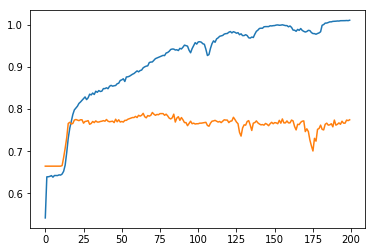

In [25]:
plt.plot(accuracy_train)
plt.plot(accuracy_val)

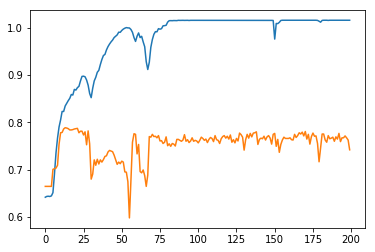

In [17]:
plt.plot(accuracy_train)
plt.plot(accuracy_val)

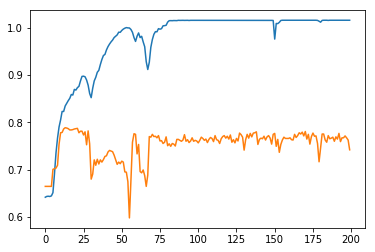

In [18]:
plt.plot(accuracy_train)
plt.plot(accuracy_val)